### 在資料集上測試 (MVtech)
資料集: 
> THE MVTEC ANOMALY DETECTION DATASET (MVTEC AD)
> https://www.mvtec.com/company/research/datasets/mvtec-ad


<img src="https://www.mvtec.com/fileadmin/Redaktion/mvtec.com/company/research/datasets/dataset_overview_large.png" alt="drawing" width="400"/>

In [1]:
!pip install -q --user albumentations

In [2]:
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import torch.optim as optim
from utils import show_image_mask, mask_CutMix, patience
from unet import UNet
import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' # for debug建議使用cpu作為torch的運行背景
device

device(type='cuda')

In [5]:
BATCH_SIZE = 16
NUM_LABELS = 1
WIDTH = 128
HEIGHT = 128
MULTI_CHS = False

In [6]:
unet = UNet(num_class=1, padding = 'same', out_sz=(WIDTH,HEIGHT), retain_dim=False)
unet#.to(device)
x    = torch.randn(1, 3, WIDTH, HEIGHT)#.to(device)
y_pred = unet(x)
y_pred.shape

del unet

In [7]:
# import os   
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [8]:
item = 'capsule'
path = os.getcwd()
img_dir = f'{path}/data/{item}/test/scratch/'
print(len(os.listdir(img_dir)))
anno_dir = f'{path}/data/{item}/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]

23


### 取得image list
輸出: data_dic (字典)
- key: X_train, X_test, y_train, y_test

In [9]:
from sklearn.model_selection import train_test_split
mask_dir = lambda anno_dir, X_lis:[anno_dir+i.split('.')[0]+'_mask.png' for i in X_lis]

imgs_path_list = sorted(os.listdir(img_dir))

size = 1/len(imgs_path_list)
size = 0.1
train, test = train_test_split(imgs_path_list, train_size = size)

key = 'X_train, X_test, y_train, y_test'.split(', ')

lis = []
for number in [train, test]:
    lis.append([img_dir+i for i in number]) # X
for number in [train, test]:
    lis.append(mask_dir(anno_dir, number)) # y
data_dic = dict(zip(key, lis))
data_dic['X_train']

['/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/016.png',
 '/home/jovyan/git/Image_Segmentation/PART2/data/capsule/test/scratch/003.png']

### Build torch dataset

In [10]:
#  https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
    def __init__(self, imgs_path_list, anno_path_list, transform=None, multi_channel=False):
        self.imgs_path_list = imgs_path_list
        self.anno_path_list = anno_path_list
        if type(imgs_path_list) != list:
            raise ValueError('Need Input a list')
        if type(anno_path_list) != list:
            raise anno_path_list('Need Input a list')
        self.transform = transform
        self.multi_channel = multi_channel
#   
    def __len__(self):
        return len(self.imgs_path_list)
#         return 32

    def __getitem__(self, idx):
        img_path = self.imgs_path_list[idx]
        file_name = img_path.split('/')[-1].split('.')[0]
        mask_path = [i for i in self.anno_path_list if i.__contains__(file_name)][0]
        
        # cv2
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (1000, 1000, 3)
#       
        # cv2
        mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE) # (1000, 1000) 
        
         
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
#         if self.target_transform:
#             transformed = target_transform(image=image, mask=mask)
#             image = transformed['image']
#             mask = transformed['mask']
        
        image = torch.Tensor(image)
        image = image.permute(2,0,1)
        
        mask = torch.Tensor(mask) 
        mask = mask.unsqueeze(0)
        mask = mask.float()/255.
        
        if self.multi_channel:
            '''
            cross entropy needed data type for multi-class predicted.
            '''
            mask = mask.squeeze(1)
            mask = mask.long()
        #print('here is the shape of return image and mask ', image.shape, mask.shape)
            
        return image, mask
    

#### 補充: 如何從dataset抽image, mask出來

In [11]:
# a = CustomImageDataset(data_dic['X_train'], data_dic['y_train']
#                        #, transform=transform
#                       )
# for idx in range(a.__len__()):
# #     print(idx)

#     test_image = a.__getitem__(idx)[0]
#     test_mask = a.__getitem__(idx)[1]
#     print(test_image.shape)
#     print(test_mask.shape)
    
#     test_image = test_image.squeeze(0).permute(1,2,0).float().numpy()
# #     print(test_image)
#     test_mask = test_mask.squeeze(0).int().numpy()
#     print(test_image.shape)
#     print(test_mask.shape)
#     show_image_mask(test_image, test_mask)

#### 補充: 取得指定影像的瑕疵位置(x_min, y_min, x_max, y_max)

In [12]:
# '''
# 可以針對某一張影像計算mask中包含瑕疵的位置在哪裡，用來對該影像作croping(裁切)，實現放大(rescale)的效果，幫助模型學習該影像對應的特徵。
# '''
# from utils import find_objects_contours, center_to_4point
# arr = find_objects_contours(test_mask)
# print(arr)
# points = center_to_4point(test_mask, arr, WIDTH, pad=50)
# print('4 POINTS , WIDTH + pad', points, points[2]-points[0])
# x_min, y_min, x_max, y_max = points

# show_image_mask(test_mask, test_mask[y_min:y_max, x_min:x_max])


# '''
# 根據上面獲得的x_min, y_min, x_max, y_max 座標，對一些訓練資料做裁切，並將裁切到的區塊存進list，並在之後用來傳入mask_CutMix參數。
# '''
# print('')

In [13]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/
from utils import mask_CutMix
transform = A.Compose([
#     mask_CutMix(img_mask_list, p=0.5),
#     A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, p=0.5),
    
    A.CenterCrop(300, 900, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
    A.Rotate((-30, 30), interpolation=0),  

    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([
    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

In [14]:
# 建議同時間只有16個(128,128)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)
BATCH_SIZE = 16
MULTI_CHANNELS = False

# 在這邊會強制對所有不滿BATCH_SIZE的訓練資料做數量上的匹配，接著透過CustomImageDataset的transform做資料擴增
if len(data_dic['X_train']) < 16: 
    lis = data_dic['X_train']
    lis = [lis[i%len(lis)] for i in range(BATCH_SIZE)]
    data_dic['X_train'] = lis
# print(data_dic['X_train'])

dataset_train = CustomImageDataset(data_dic['X_train'], data_dic['y_train'], transform=transform, multi_channel=MULTI_CHANNELS)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                                               pin_memory=True,
                                              )
# dataloader_train = iter(dataloader_train)
dataset_test = CustomImageDataset(data_dic['X_train'], data_dic['y_train'], transform=target_transform, multi_channel=MULTI_CHANNELS) # **如果要正式使用要記得把這裡換成X_test
# dataset_test = CustomImageDataset(data_dic['X_test'], data_dic['y_test'], transform=target_transform, multi_channel=MULTI_CHANNELS)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=len(data_dic['X_test']), shuffle=False, pin_memory=True)


2
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


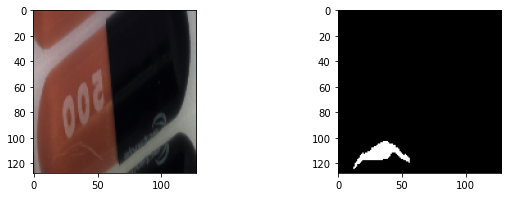

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


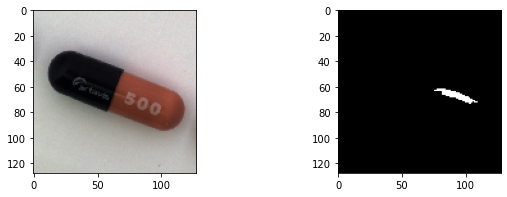

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


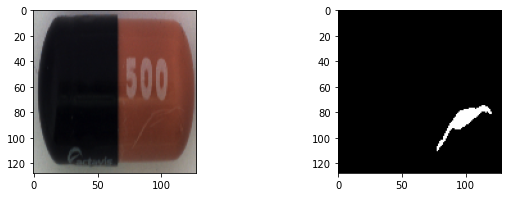

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


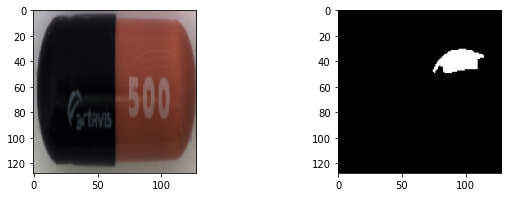

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


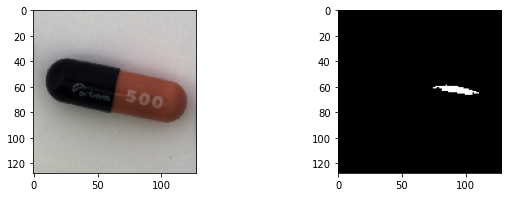

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


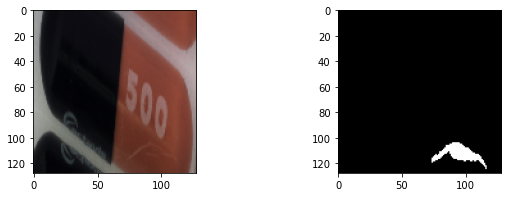

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


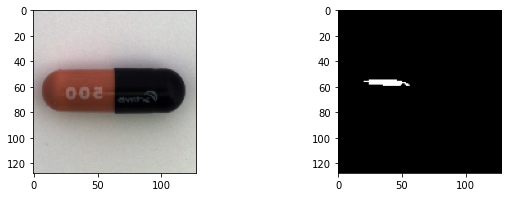

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


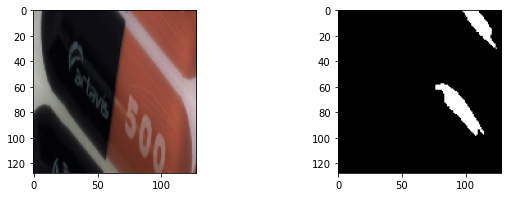

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


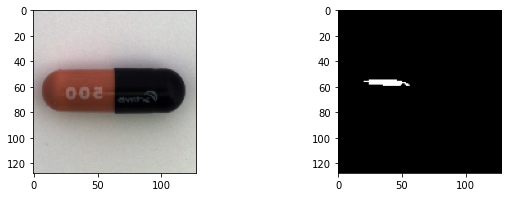

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


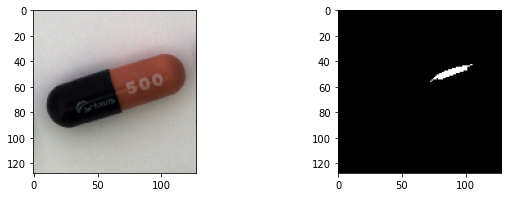

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


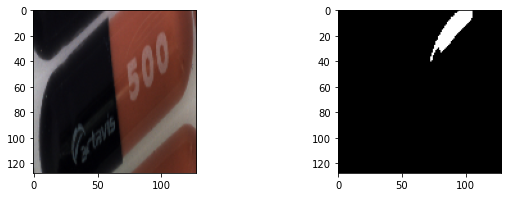

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


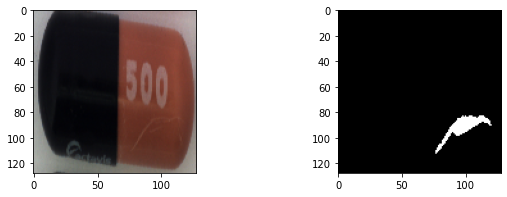

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


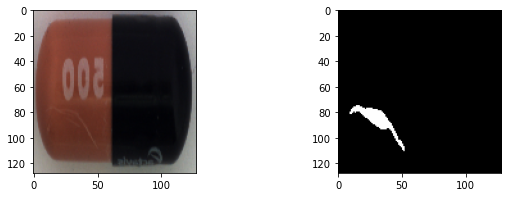

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


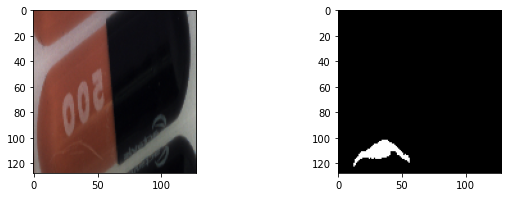

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


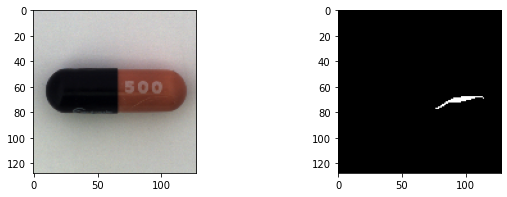

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


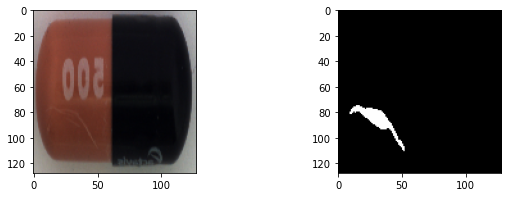

In [15]:
'''test transform on dataloader_train'''
for data in dataloader_train:
    print(len(data))
    for x, y in zip(*data):
        
        print(x.shape)
        print(y.shape)
        show_image_mask(x.squeeze(0).permute(1,2,0).numpy(), y.squeeze(0).int())

### BCE_with_logit
二元分類，只有一個channel的輸出的場合。

In [16]:
# NUM_LABELS = 1
# activation = nn.ReLU()
# model = UNet(num_class=NUM_LABELS, out_sz=(WIDTH,HEIGHT), activation=activation)
# model.to(device) 
# '''
# 要在建立optimizer之前就把model的參數移到gpu裡面 
# ref: https://pytorch.org/docs/stable/optim.html 
# '''

# criterion = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100]).to(device))
# optimizer = optim.Adam(model.parameters(), lr = 1e-3)

### CE
交叉熵誤差，用於有多個channel的輸出的場合。

In [17]:
NUM_LABELS = 2
activation = nn.Sigmoid()
model = UNet(num_class=NUM_LABELS, out_sz=(WIDTH,HEIGHT), activation=activation)
model.to(device) 
'''
要在建立optimizer之前就把model的參數移到gpu裡面  
ref: https://pytorch.org/docs/stable/optim.html 
'''

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

## 訓練模型

In [18]:
# model = torch.load('save.pt')

In [19]:
best_loss = None
monitor = patience(None)
times_to_show = 50

for epoch in range(501):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0
    
    if monitor.early_stop:
        break
        
    monitor.time(times_to_show=50, show=True)
        
    for i, data in enumerate(dataloader_train, 1): # get each batch, setting drop_last
        inputs, mask = data
        inputs = inputs.to(device)
        mask = mask.to(device)
#         print('mask',mask.shape, mask.dtype)
#         print('inputs', inputs.shape)

        
        # zero the parameter gradients
        for param in model.parameters():
            param.grad = None
#         optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
#         outputs = outputs.long()
#         print('outputs',outputs.shape, outputs.dtype)

        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        running_loss = running_loss/len(inputs)
        print(f'epochs: {epoch}, average sample loss: {running_loss:.8f}')

        if not best_loss:
            best_loss = running_loss
        elif running_loss < 0.9*best_loss:
            best_loss = running_loss
            torch.save(model, 'saved/best_save.pt')
            monitor.reset()
            print('save torch model [best_save.pt]')

        monitor.record()
        running_loss = 0.0

torch.save(model, 'saved/last_save.pt')
        
# print('Finished Training')

0 epochs passed, ptime monitor every 50 epoch ['0.000']


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss2d_forward

### 觀察訓練結果
由於時間有限，我們在這裡只觀察對「訓練資料集」進行訓練後的結果，預期狀態模型應該實現over-fit在訓練資料上。

In [ ]:
for i, data in enumerate(dataloader_test, 1):
    image, mask = data
    print(len(inputs))
    
    image = image.to(device)
    mask = mask.to(device)
    
#     print(image.shape)
    outputs = model(image)
    loss = criterion(outputs, mask)
    print(loss)

    img_process = lambda image:image.cpu().permute(0,2,3,1)
    mask_process = lambda mask:mask.cpu().squeeze(1).permute(0,1,2)

    for x, m, p in zip(image.cpu().permute(0,2,3,1), mask_process(mask), mask_process(outputs)):
        show_image_mask(x, m, p)
